In [1]:
#library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import scipy
from scipy.integrate import solve_ivp
from scipy.stats import ttest_ind
from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LinearRegression

In [25]:
'''
PARAMETERS
'''

#define parameters
n_species = 4
n_cs = 10 # cs = carbon sources

#default values
g = np.ones(n_species) # conversion factor from energy uptake to growth rate, for species i ## all 1's, so all the energy is converted into growth ?
m = np.zeros(n_species) # minimal energy uptake for maintenance of species (energy/time)
l = 0.1*np.ones((n_species, n_cs)) # leakage fractions for resource 'a' (unitless)
K = 1e-1*np.ones(n_cs) # consider making this small (affinity)
w = np.ones(n_cs) # all metabolites have the same energy
d = 0.1 # dilution rate
c =  np.ones((n_species,n_cs)) #MAX uptake of a ressource a by a species i
J = np.zeros((n_species, n_cs)) #energie intake d'in individu i par une ressource a
D = np.full((n_species, n_cs, n_cs),0.05) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a

print(c)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [3]:
N0 = [ # list of initial population densities
    1e-4, # species 1
    1e-4, # species 2
    1e-4, # species 3
    1e-4  # species 4
    ]
R0 = np.zeros(n_cs) # concentration of resources at t=0 (mass/volume)
R0[0] = 10 # first resource has a concentration of 10 (why ?) parce que après on va peut être obtenir les autres ressources grace aux byproduct
y0 = np.append(np.array(N0),R0)

In [4]:
'''
MODEL 1 : CR_model
'''

# complete model
def CR_model(t, y, c, K, w, l, m, g, d, D):

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a]) # uptake ~ max uptake, resource concentration, affinity

  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum([(J[i, a]*w[a]*(1-l[i,a]))-m[i]for a in range(n_cs)]) # growth ~ uptake, energy content of resource, leakage, maintenance
                                                                                 # -> sum of every resource
    dNdt[i] = g[i]*N[i]*growth_intake-(N[i]*d) # population evolution ~ conversion rate, population, growth intake, dilution rate

  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake
                                                                  # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i,b] = D[i,a,b]*w[b]*l[i,b]*N[i]*J[i,b]/w[a] # production ~ fraction converted, energy content, leakage, population, uptake
    byproduction = np.sum(byproduction_tot) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a])*d - consumption + byproduction # resource evolution ~ dilution, consumption, byproduct production

  return np.concatenate((dNdt,dRdt))

In [14]:
t_span = (0,100)
t_eval = np.linspace(t_span[0], t_span[1],300)

In [15]:
#solution of the model
c[0,0] = 0.5
c[1,0] = 0.75
c[2,0] = 0
c[3,1] = 0
c[1,1] = 0
c[2,1] = 0.2
c[0,1] = 0.2
c[0,2] = 0.1
c[1,2] = 0
c[2,2] = 0.6
c[3,2] = 0
c[0,3] = 0
c[1,3] = 0.2
c[2,3] = 0
c[3,3] = 0
print(c)

solutions = solve_ivp(CR_model, t_span, y0, args=(c, K, w, l, m, g, d, D), method = "BDF")

[[0.5        0.2        0.1        0.         0.77677256 0.71056572
  0.38377263 0.77914207 0.26322505 0.87711832]
 [0.75       0.         0.         0.2        0.08494887 0.67624378
  0.88955845 0.31095062 0.02878954 0.46539073]
 [0.         0.2        0.6        0.         0.84609827 0.03948347
  0.04662426 0.72145588 0.78225782 0.36136477]
 [0.3424102  0.         0.         0.         0.05182097 0.21015365
  0.92935446 0.80931648 0.79481433 0.74608731]]


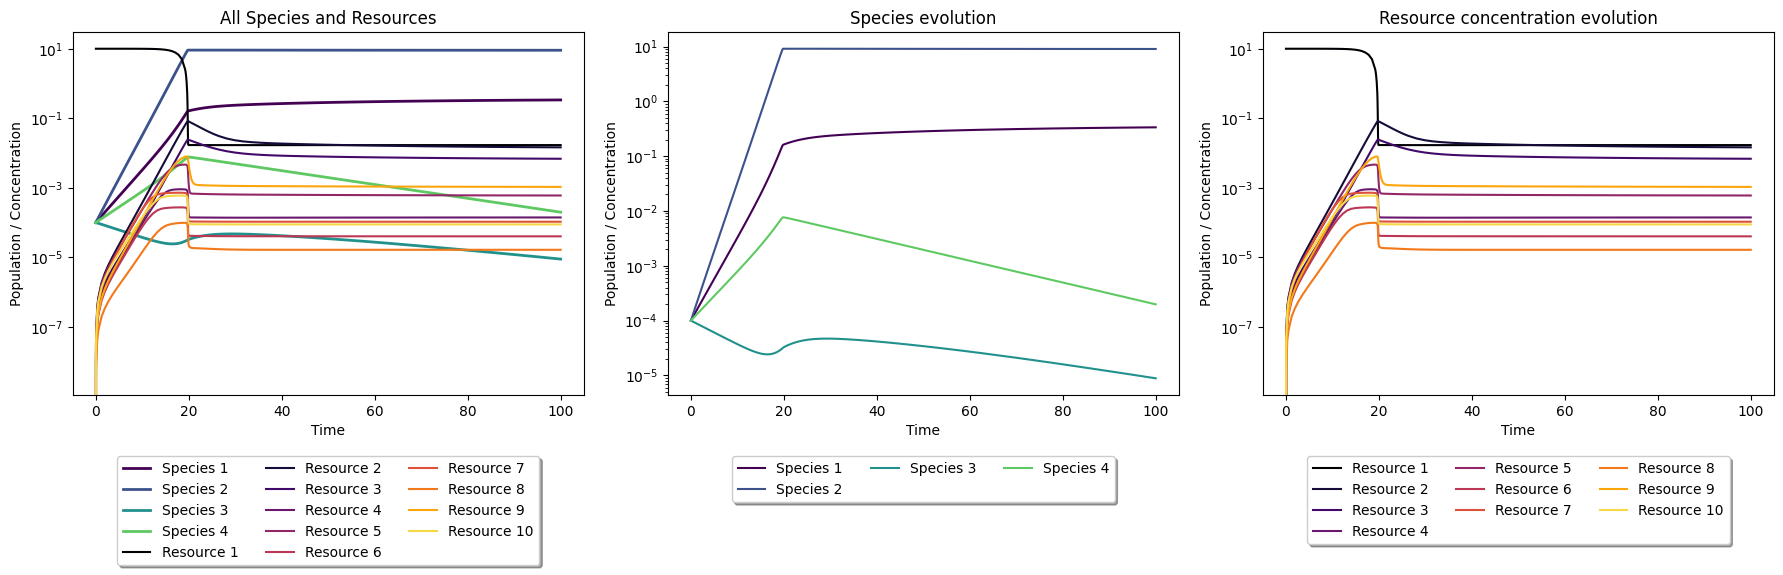

In [16]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [8]:
#Randomisation of some parameters
#c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs)) #matrice du by product d'une ressource b produit par un individu i consommant une ressource a)


In [9]:
t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)
solutions2 = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")

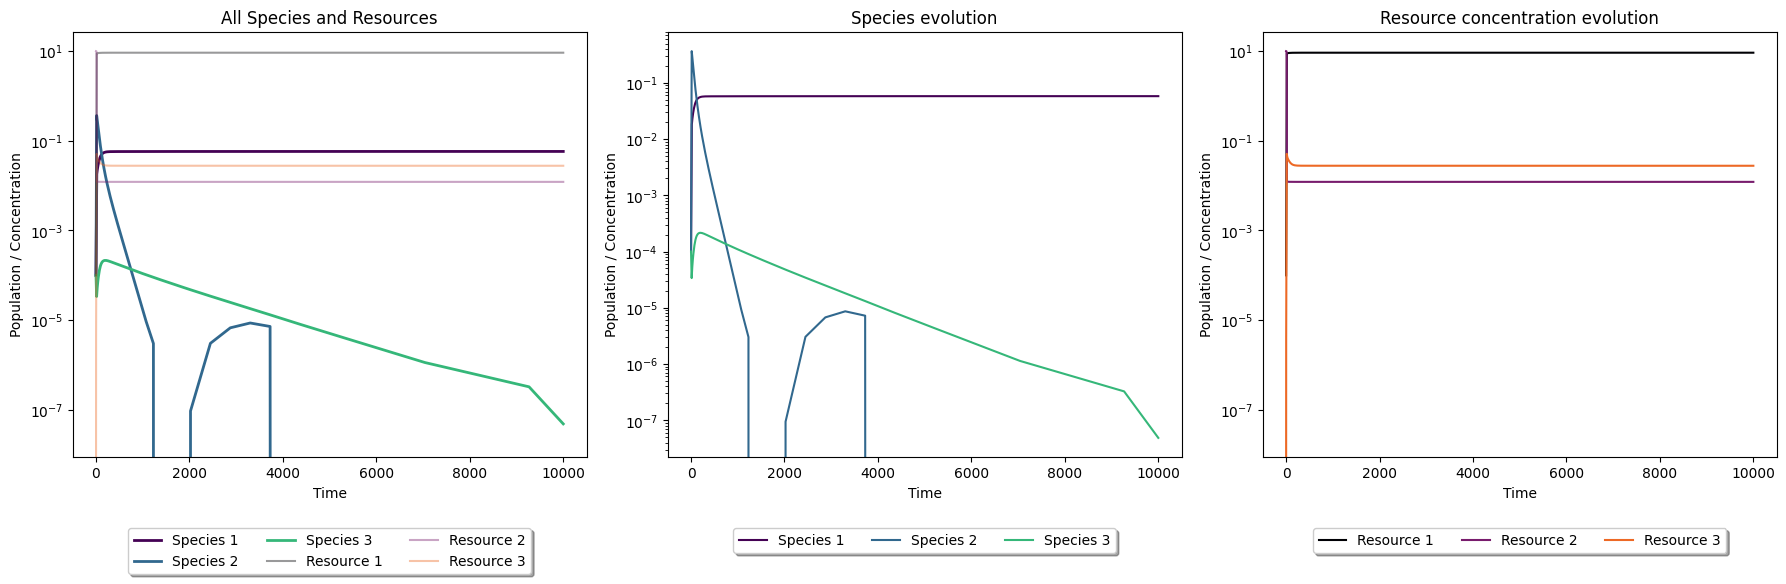

In [64]:
# better plot for solutions *2* ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions2.t,
                solutions2.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions2.t,
                solutions2.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [11]:
#random multiple simulations
t_span = (0,100000)
t_eval = np.linspace(t_span[0], t_span[1],300)
sim_dict = {}
for i in range(20):
  c = np.random.uniform(low = 0, high = 1,size = (n_species,n_cs))
  D = np.random.uniform(low = 0, high = 0.1,size=(n_species, n_cs, n_cs))
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]


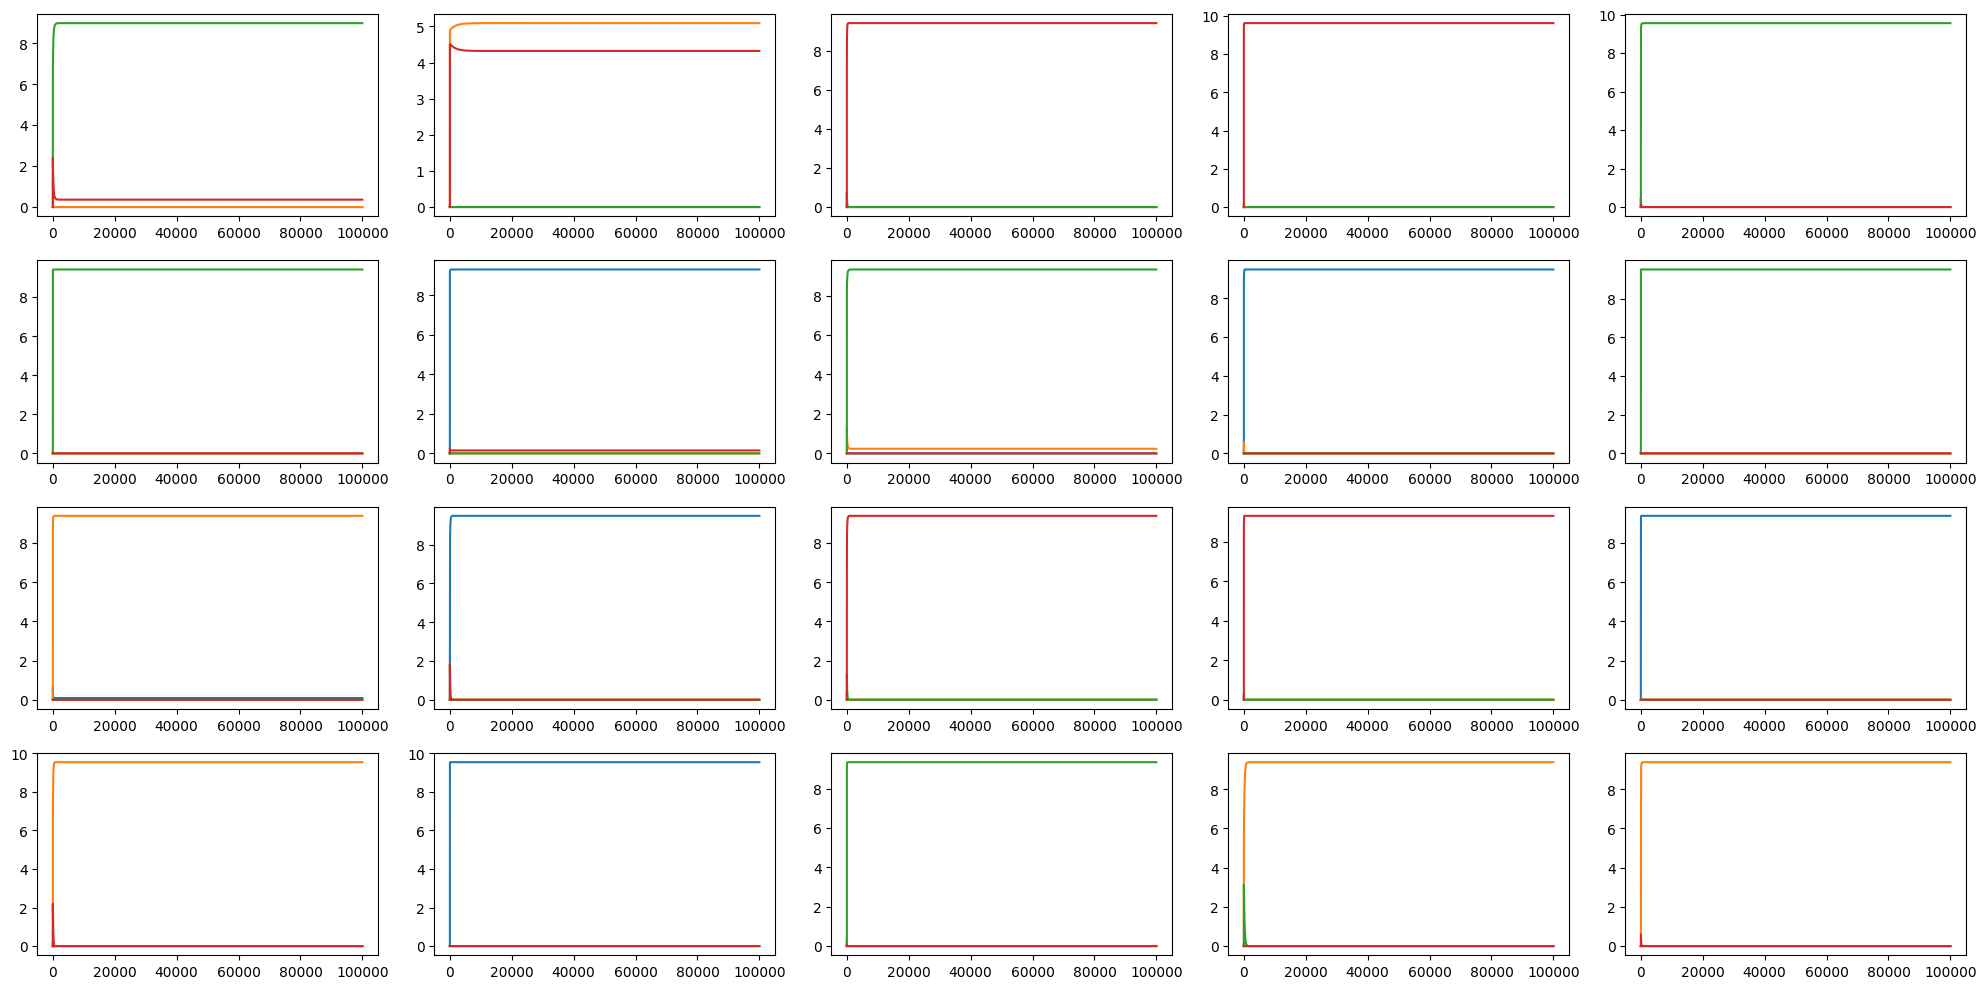

In [12]:
#plotting usinage
#trash

fig, axs = plt.subplots(4,5,figsize = (20,10))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()


In [60]:
'''
MODEL 2 : CR_model_simple
- 3 cs, 3 species (keep it simple)
- w = 1, m = 0, l=0, d=0
- vary K ? and other parameters ?
- (arbitrary values)
'''

# PARAMETERS

# starting population and resource densities -> 3 species and 3 cs for the simple model
n_species = 3
N0 = np.ones(n_species) # list of initial population densities
N0[0] = 10  # species 1
N0[1] = 20  # species 2
N0[2] = 30  # species 3

n_cs = 3 # cs = carbon sources
R0 = np.zeros(n_cs) # list of initial resource concentrations
R0[0] = 10  # resource 1
R0[1] = 20  # resource 2
R0[2] = 30  # resource 3

y0 = np.append(np.array(N0),R0) # starting state


g = np.ones(n_species) # CONVERSION FACTOR from energy uptake to growth rate, for each species
g[0] = 0.25   #species 1
g[1] = 0.50   #species 2
g[2] = 0.75   #species 3


K = np.ones(n_cs) # AFFINITY of each resource (consider making this small)
K[0] = 0.01   #resource 1
K[1] = 0.02   #resource 2
K[2] = 0.03   #resource 3


c =  np.ones((n_species,n_cs)) # MAX UPTAKE of a ressource a by a species i
c[0,0] = 1   #species 1 resource 1
c[0,1] = 1   #species 1 resource 2
c[0,2] = 1   #species 1 resource 3

c[1,0] = 1   #species 2 resource 1
c[1,1] = 1   #species 2 resource 2
c[1,2] = 1   #species 2 resource 3

c[2,0] = 1   #species 3 resource 1
c[2,1] = 1   #species 3 resource 2
c[2,2] = 1   #species 3 resource 3


J = np.zeros((n_species, n_cs)) # ENERGY INTAKE d'in individu i par une ressource a
J[0,0] = 1   #species 1 resource 1
J[0,1] = 1   #species 1 resource 2
J[0,2] = 1   #species 1 resource 3

J[1,0] = 1   #species 2 resource 1
J[1,1] = 1   #species 2 resource 2
J[1,2] = 1   #species 2 resource 3

J[2,0] = 1   #species 3 resource 1
J[2,1] = 1   #species 3 resource 2
J[2,2] = 1   #species 3 resource 3


D = np.ones((n_species, n_cs, n_cs)) # BYPRODUCT produced by species a from resource i
D[0,0] = 0.1   #species 1 resource 1
D[0,1] = 0.2   #species 1 resource 2
D[0,2] = 0.3   #species 1 resource 3

D[1,0] = 0.4   #species 2 resource 1
D[1,1] = 0.5   #species 2 resource 2
D[1,2] = 0.6   #species 2 resource 3

D[2,0] = 0.7   #species 3 resource 1
D[2,1] = 0.8   #species 3 resource 2
D[2,2] = 0.9   #species 3 resource 3



In [61]:
# MODEL
def CR_model_simple(t,y) :

  N = y[:n_species]
  R = y[n_species:]
  R[R<0] = 0 #no negative values
  N[N<1e-6] = 0 #no negative values

  # resource uptake
  J = np.zeros((n_species, n_cs)) # uptake of resource i by species a
  for i in range(n_species): # for every resource
    for a in range(n_cs): # for every species
      J[i,a] = c[i,a]*R[a]/(R[a]+K[a]) # uptake ~ max uptake, resource concentration, affinity

 # population variation
  dNdt = np.zeros(n_species) # variation in population ~ resource uptake
  for i in range(n_species): # for every species
    growth_intake = np.sum([(J[i, a])for a in range(n_cs)]) # growth ~ uptake, energy content of resource // NO LEAKAGE, NO MAINTENANCE
                                                                                 # -> for every resource, added up
  dNdt[i] = g[i]*N[i]*growth_intake # population evolution ~ conversion rate, population, growth intake // NO DILUTION

  # resource variation
  dRdt = np.zeros(n_cs) # variation in resource ~ consumption and byproduct production
  for a in range(n_cs): # for every resource
    consumption = np.sum([N[i]*J[i,a] for i in range(n_species)]) # consumption ~ population, resource uptake

    # byproduct formation                                                                 # -> sum for every species
    byproduction_tot = np.zeros((n_species, n_cs)) # byproduct production
    for i in range(n_species): # for every species
      for b in range(n_cs): # for every resource
        byproduction_tot[i,b] = D[i,a,b]*N[i]*J[i,b] # production ~ fraction converted, energy content, population, uptake // NO LEAKAGE, NO VAR IN RESOURCE ENERGY CONTENT
    byproduction = np.sum(byproduction_tot) # add all byproduct production FOR ONE RESOURCE (see [24])
    dRdt[a] = (R0[a]-R[a]) - consumption + byproduction # resource evolution ~ consumption, byproduct production // NO DILUTION

  return np.concatenate((dNdt,dRdt))

In [62]:
# DEFINE TIMEFRAME, SEARCH SOLUTIONS
t_span = (0,200)
solutions_simple = solve_ivp(CR_model_simple, t_span, y0, method = "BDF")

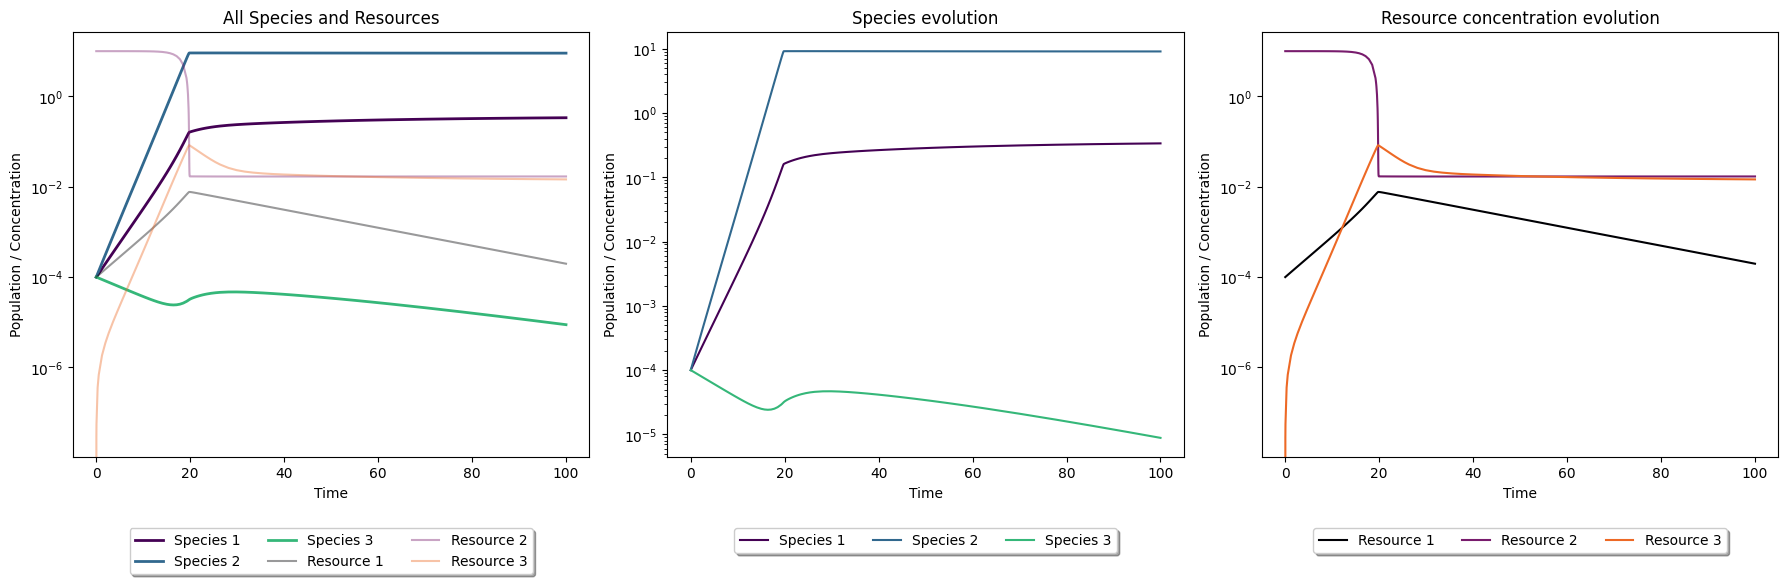

In [63]:
# better plot for solutions ?

legend_species = [f"Species {i}" for i in range(1, n_species+1)]
legend_cs = [f"Resource {i}" for i in range (1, n_cs+1)]

cmap_species = cm.viridis
colors_species = [cmap_species(i / n_species) for i in range(n_species)]

cmap_cs = cm.inferno
colors_cs = [cmap_cs(i / n_cs) for i in range(n_cs)]


fig, axs = plt.subplots(1,3, figsize=(18, 6))

# Premier graphique avec tout
for i in range(n_species):
    axs[0].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i],
                linewidth=2.0)
for i in range(n_cs):
    axs[0].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i],
                alpha = 0.4)
axs[0].set_yscale('log')
axs[0].set_title('All Species and Resources')

# Deuxième graphique avec seulement les espèces
for i in range(n_species):
    axs[1].plot(solutions.t,
                solutions.y[i],
                label=legend_species[i],
                color=colors_species[i])
axs[1].set_yscale('log')
axs[1].set_title('Species evolution')

# Troisième graphique avec seulement les cs
for i in range(n_cs):
    axs[2].plot(solutions.t,
                solutions.y[i+n_species],
                label=legend_cs[i],
                color=colors_cs[i])
axs[2].set_yscale('log')
axs[2].set_title('Resource concentration evolution')

# Titres et légendes
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Population / Concentration')
    ax.legend(loc='upper center',
              bbox_to_anchor=(0.5, -0.15),
              fancybox=True,
              shadow=True,
              ncol=3)

plt.tight_layout()
plt.show()

In [13]:
#trash

cohabitation_data = {"sim":[], "c" :[], "D" : []}

domination_data = {"sim":[],"c":[], "D":[]}

for i in range(len(sim_dict)):
  index_alive = []
  for a in range(n_species):
    if sim_dict[f"simulation {i}"][1].y[a][-1:] > 1e-9:
      index_alive.append(a)
  if len(index_alive) > 1:
    cohabitation_data["sim"].append(f"simulation {i}")
    cohabitation_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    cohabitation_data["D"].append(sim_dict[f"simulation {i}"][0][1])
  else:
    domination_data["sim"].append(f"simulation {i}")
    domination_data["c"].append(sim_dict[f"simulation {i}"][0][0])
    domination_data["D"].append(sim_dict[f"simulation {i}"][0][1])

cohabitation_df = pd.DataFrame(cohabitation_data)
domination_df = pd.DataFrame(domination_data)
cohabitation_df.head()


,sim,c,D
0,simulation 0,"[[0.4634174228165495, 0.18455718171477198, 0.4...","[[[0.07084777167403854, 0.09027749504794674, 0..."
1,simulation 1,"[[0.3686076287678164, 0.1267588980439489, 0.73...","[[[0.02212378510481987, 0.022742662572869356, ..."
2,simulation 6,"[[0.7816551556608557, 0.16809611304662064, 0.0...","[[[0.02126284643562445, 0.09672329238184518, 0..."
3,simulation 7,"[[0.09472961705800309, 0.6075775853971671, 0.1...","[[[0.0761586673021013, 0.06779944745937265, 0...."
4,simulation 10,"[[0.7563398198428937, 0.5639933814589313, 0.25...","[[[0.07811363322420822, 0.05732539519961798, 0..."


In [ ]:
# Statistical analysis
#trash
'''
sum_cohab = np.array([i.flatten() for i in cohabitation_df["D"]])
sum_domi = np.array([i.flatten() for i in domination_df["D"]])
pca = PCA(n_components=5)
t_stat, p_value = mannwhitneyu(sum_cohab, sum_domi)
p_value
'''

'\nsum_cohab = np.array([i.flatten() for i in cohabitation_df["D"]])\nsum_domi = np.array([i.flatten() for i in domination_df["D"]])\npca = PCA(n_components=5)\nt_stat, p_value = mannwhitneyu(sum_cohab, sum_domi)\np_value\n'

In [ ]:
# banque of c for simulation
'''
c =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i
c_temp = c.copy()
c_banq = []
for i in range(n_species):
  for j in range (10):
    c_temp[i,i] -=0.1
    c_banq.append(c_temp)

t_span = (0,10000)
t_eval = np.linspace(t_span[0], t_span[1],300)

sim_dict = {}
for i in range(len(c_banq)):
  c = c_banq[i]
  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")
  sim_dict[f"simulation {i}"] = [[c,D],sol]
'''

'\nc =  np.ones((n_species,n_cs)) #maximum uptake of a ressource a by a species i\nc_temp = c.copy()\nc_banq = []\nfor i in range(n_species):\n  for j in range (10):\n    c_temp[i,i] -=0.1\n    c_banq.append(c_temp)\n\nt_span = (0,10000)\nt_eval = np.linspace(t_span[0], t_span[1],300)\n\nsim_dict = {}\nfor i in range(len(c_banq)):\n  c = c_banq[i]\n  sol = solve_ivp(CR_model, t_span, y0,args=(c, K, w, l, m, g, d, D), method = "BDF")\n  sim_dict[f"simulation {i}"] = [[c,D],sol]\n'

In [ ]:
'''
fig, axs = plt.subplots(10,4,figsize = (20,20))

for ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):
  ax.plot(value[1].t, value[1].y[0], label='Species 1')
  ax.plot(value[1].t, value[1].y[1], label='Species 2')
  ax.plot(value[1].t, value[1].y[2], label='Species 3')
  ax.plot(value[1].t, value[1].y[3], label='Species 4')  #ax.set_yscale("log")
plt.tight_layout()
plt.show()
'''

'\nfig, axs = plt.subplots(10,4,figsize = (20,20))\n\nfor ax, key, value in zip(axs.ravel(), sim_dict.keys(), sim_dict.values()):\n  ax.plot(value[1].t, value[1].y[0], label=\'Species 1\')\n  ax.plot(value[1].t, value[1].y[1], label=\'Species 2\')\n  ax.plot(value[1].t, value[1].y[2], label=\'Species 3\')\n  ax.plot(value[1].t, value[1].y[3], label=\'Species 4\')  #ax.set_yscale("log")\nplt.tight_layout()\nplt.show()\n'